В рамках ранее выполненной работы по обработке данных с pandas (credit_train.csv) через SQL-запросы реализовать следующее: 
- разбить выборку на обучающую и тестовую
- проанализировать пропуски и решить, что с ними делать
- проанализировать выбросы
- создать/ удалить переменные
- закодировать категориальные переменные
- нормализовать числовые переменные (при необходимости)



In [186]:
import matplotlib.pyplot as plt
import pandas as pd
import pymorphy2
import sqlite3
import re

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import normaltest


In [58]:
csv_path = 'credit_train.csv'

# read to DataFrame from csv with cp1251 encoding and ; delimeter
credit_df = pd.read_csv(csv_path, encoding='cp1251', delimiter=';')


In [59]:
# create connector to sqlite database
con = sqlite3.connect('db_2024-12-19')


In [60]:
# add table to database
table_name = 'credit_train'
credit_df.to_sql(table_name, con, index=False, if_exists='replace')


170746

In [61]:
# function for select data from table
def select(sql: str):
    global con

    return pd.read_sql(sql, con)


In [62]:
select(f'SELECT * FROM {table_name}')


,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,None,UMN,"59998,00",10,1.60,None,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,"10889,00",6,1.10,None,None,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,"10728,00",12,1.10,None,None,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,None,SPC,"12009,09",12,1.10,None,None,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,None,SPC,None,10,1.10,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27.0,UNM,SPC,"64867,00",12,1.10,"0,535257",GRD,РЕСПУБЛИКА ТАТАРСТАН,40000.0,6.0,0.0,0
170742,170743,F,24.0,MAR,SPC,"17640,00",6,1.60,"0,573287",SCH,САНКТ-ПЕТЕРБУРГ Г,30000.0,1.0,0.0,0
170743,170744,F,31.0,UNM,SPC,"27556,47",10,1.32,"0,416098",GRD,ПРИМОРСКИЙ КРАЙ,40000.0,1.0,0.0,0
170744,170745,F,53.0,DIV,PNA,"6189,00",12,1.10,"0,482595",SCH,ПЕНЗЕНСКАЯ ОБЛ,31000.0,2.0,0.0,0


In [63]:
# get table columns names
columns_list = select(f'SELECT name FROM pragma_table_info("{table_name}")').name.tolist()
print('Table columns:\n', columns_list, '\n')

# create sql-request to get rows without nan values
nan_sql = ''
for name in columns_list:
    request_str = f' {name} is not null '
    nan_sql = 'and'.join([nan_sql, request_str]) if nan_sql else request_str

not_nans_df = select(f'SELECT * FROM {table_name} WHERE' + nan_sql)

print('Table without nans:\n', not_nans_df)


Table columns:
 ['client_id', 'gender', 'age', 'marital_status', 'job_position', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'education', 'living_region', 'monthly_income', 'credit_count', 'overdue_credit_count', 'open_account_flg'] 

Table without nans:
         client_id gender   age marital_status job_position credit_sum  \
0               8      F  26.0            UNM          SPC   47878,00   
1              10      F  32.0            UNM          SPC   26268,00   
2              11      M  26.0            MAR          SPC   16793,00   
3              13      M  37.0            MAR          SPC   42289,00   
4              14      M  43.0            MAR          INP   57567,00   
...           ...    ...   ...            ...          ...        ...   
161326     170742      F  27.0            UNM          SPC   64867,00   
161327     170743      F  24.0            MAR          SPC   17640,00   
161328     170744      F  31.0            UNM          SPC   27556,47   
16

Как видно, кол-во строк таблицы, не содержащих пропуски, составило 161331 из 170746 (94.49%), что относительно много, следовательно, строки с пропусками можно исключить.

In [64]:
# add new table without nans to database
table_name_not_nans = 'credit_train_not_nans'
not_nans_df.to_sql(table_name_not_nans, con, index=False, if_exists='replace')


161331

Из информации ниже видно, что у столбцов 'credit_sum' и 'score_shk' тип данных 'TEXT', вместо числового. Конвертируем значения этих колонок в тип 'REAL'. 

In [65]:
# show info about table columns 
table_info_sql = f'SELECT * FROM pragma_table_info("{table_name_not_nans}")'
select(table_info_sql)


,cid,name,type,notnull,dflt_value,pk
0,0,client_id,INTEGER,0,None,0
1,1,gender,TEXT,0,None,0
2,2,age,REAL,0,None,0
3,3,marital_status,TEXT,0,None,0
4,4,job_position,TEXT,0,None,0
5,5,credit_sum,TEXT,0,None,0
6,6,credit_month,INTEGER,0,None,0
7,7,tariff_id,REAL,0,None,0
8,8,score_shk,TEXT,0,None,0
9,9,education,TEXT,0,None,0


In [ ]:
# replace comma to dot in columns 'score_shk', 'credit_sum', convert TEXT columns type to REAL
con.executescript(f'''ALTER TABLE {table_name_not_nans} ADD COLUMN score_shk_real REAL;
                      ALTER TABLE {table_name_not_nans} ADD COLUMN credit_sum_real REAL;
                      UPDATE {table_name_not_nans}
                      SET score_shk_real = CAST(replace(score_shk, ',', '.') AS REAL);
                      UPDATE {table_name_not_nans}
                      SET credit_sum_real = CAST(replace(credit_sum, ',', '.') AS REAL);
                      ALTER TABLE {table_name_not_nans} DROP COLUMN score_shk;
                      ALTER TABLE {table_name_not_nans} DROP COLUMN credit_sum;''')

# update dataframe
show_table_sql = f'SELECT * FROM {table_name_not_nans}'
not_nans_df = select(show_table_sql)

select(f'''SELECT score_shk_real, credit_sum_real FROM {table_name_not_nans}''')


,score_shk_real,credit_sum_real
0,0.512525,47878.00
1,0.465026,26268.00
2,0.445430,16793.00
3,0.691609,42289.00
4,0.341164,57567.00
...,...,...
161326,0.535257,64867.00
161327,0.573287,17640.00
161328,0.416098,27556.47
161329,0.482595,6189.00


Столбцы 'credit_sum' и 'score_shk' заменены на 'credit_sum_real' и 'score_shk_real' с типом данных REAL:

In [67]:
select(table_info_sql)


,cid,name,type,notnull,dflt_value,pk
0,0,client_id,INTEGER,0,None,0
1,1,gender,TEXT,0,None,0
2,2,age,REAL,0,None,0
3,3,marital_status,TEXT,0,None,0
4,4,job_position,TEXT,0,None,0
5,5,credit_month,INTEGER,0,None,0
6,6,tariff_id,REAL,0,None,0
7,7,education,TEXT,0,None,0
8,8,living_region,TEXT,0,None,0
9,9,monthly_income,REAL,0,None,0


Оцениваем выбросы в таблице. Проверяем, сколько значений для численных колонок выходят за пределы интервала [mean - 3std; mean + 3std].

In [68]:
# get border values for interval [mean - 3std; mean + 3std]
def get_borders(numeric_column: str):
    numeric_3std_intervals = select(f'''SELECT  
                                        (avg({numeric_column}) - sqrt(avg({numeric_column} * {numeric_column}) - avg({numeric_column}) * avg({numeric_column})) * 3) 
                                        AS lower, 
                                        (avg({numeric_column}) + sqrt(avg({numeric_column} * {numeric_column}) - avg({numeric_column}) * avg({numeric_column})) * 3)
                                        AS upper
                                        FROM {table_name_not_nans}''')

    return numeric_3std_intervals.loc[0]


In [69]:
# function for analyse emission values outside intervals [mean - 3std; mean + 3std] for each numeric column
def emission_analysis(numeric_columns: list):
    for numeric_column in numeric_columns:
        lower_border, upper_border = get_borders(numeric_column)

        emissions_count = select(f'''SELECT count(*) AS em_count FROM {table_name_not_nans} 
                                     WHERE {numeric_column} < {lower_border} OR {numeric_column} > {upper_border}''')

        print('Emissions count for column', numeric_column, 'is', emissions_count.em_count.loc[0])


In [70]:
# create sql-request to find numeric columns
numeric_columns = select(f'''SELECT name FROM pragma_table_info("{table_name_not_nans}") 
                             WHERE type in ("INTEGER", "REAL") AND name != "client_id"''').name.tolist()
numeric_columns


['age',
 'credit_month',
 'tariff_id',
 'monthly_income',
 'credit_count',
 'overdue_credit_count',
 'open_account_flg',
 'score_shk_real',
 'credit_sum_real']

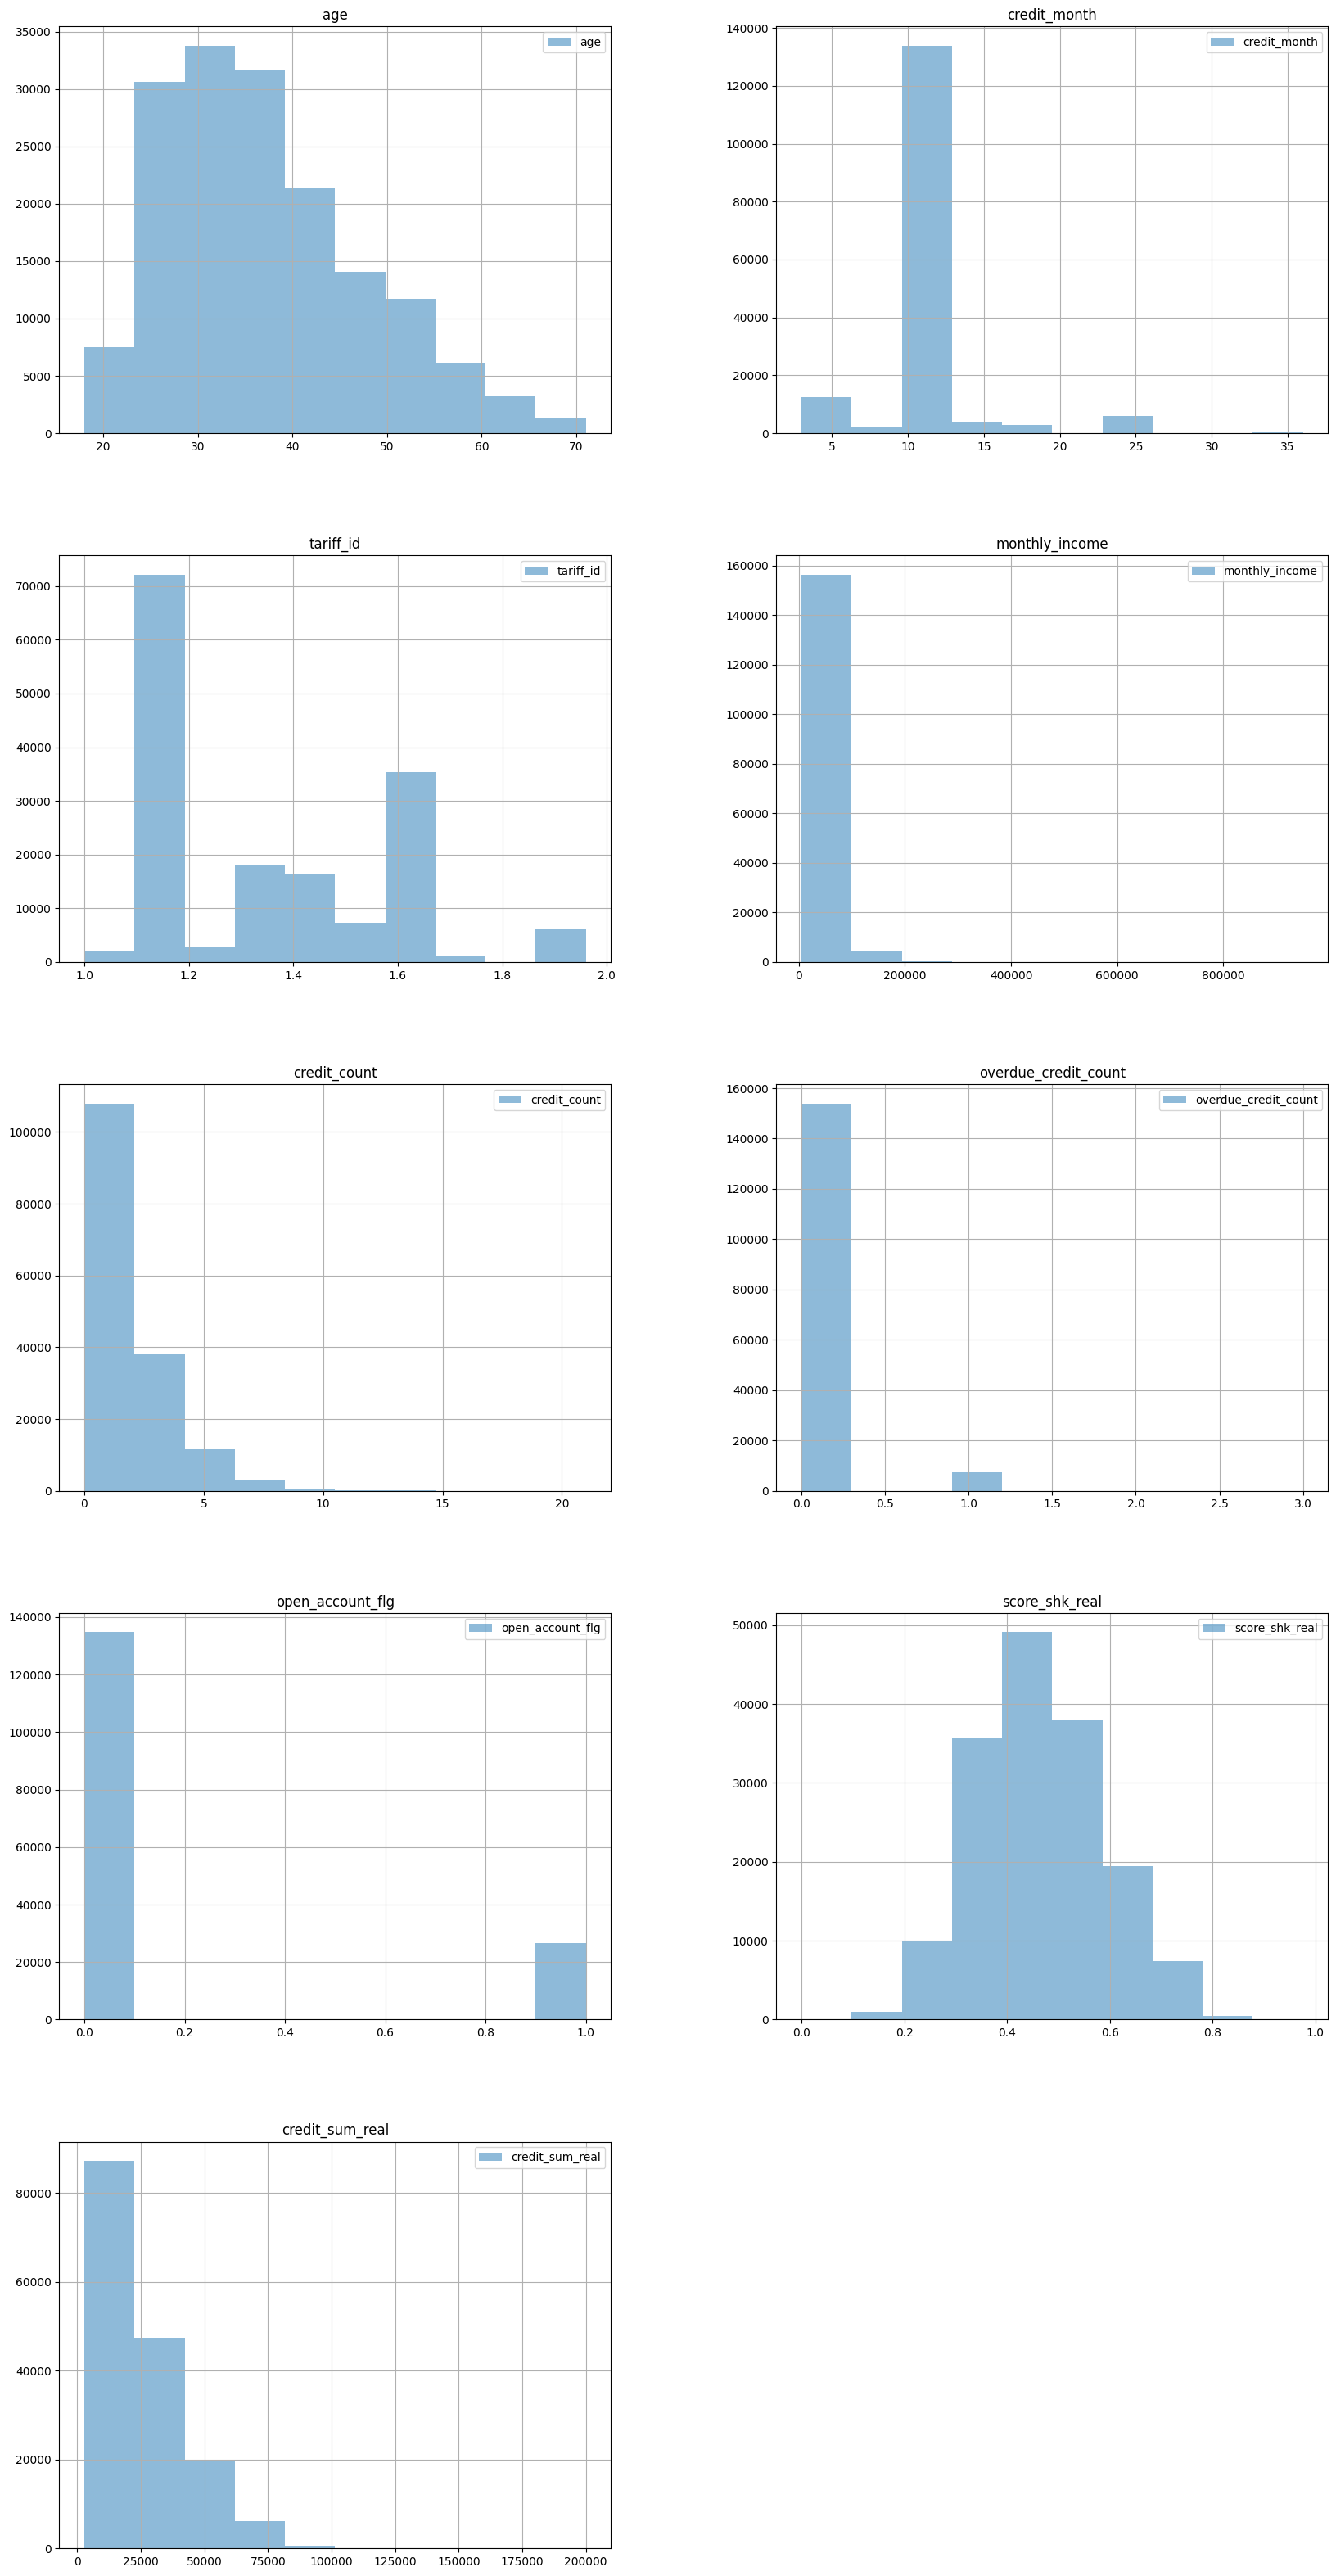

Emissions count for column age is 346
Emissions count for column credit_month is 6371
Emissions count for column tariff_id is 0
Emissions count for column monthly_income is 2224
Emissions count for column credit_count is 1982
Emissions count for column overdue_credit_count is 7372
Emissions count for column open_account_flg is 0
Emissions count for column score_shk_real is 118
Emissions count for column credit_sum_real is 1808


In [73]:
# visualize distribution plots for numeric columns in non-nans table
not_nans_df[numeric_columns].hist(layout=(5, 2), figsize=(20, 40), bins=10, alpha=0.5, grid=True, legend=True) 
plt.show()

emission_analysis(numeric_columns)


Оцениваем нормальность распределения значений числовых столбцов по критерию Пирсона: 

In [74]:
# function for calculate Pearson criterion
def pirson_norm_test(column_df: pd.DataFrame):
    global ALPHA

    statistic, p = normaltest(column_df, axis=None)

    if pd.isna(statistic):
        statistic = 0.
    if pd.isna(p):
        p = 0.

    print('Column', column_df.columns[0], '\n\tStatistic value -', round(statistic, 2), 'probability -', p, end='')
    print('\tNORMAL' if p > ALPHA else '\tUBNORMAL')


In [75]:
# check if distribution is normal for every numeric column
ALPHA = 0.05

print('PIRSON TEST for numeric columns')
for column in numeric_columns:
    column_df = select(f'SELECT {column} FROM {table_name_not_nans}')
    pirson_norm_test(column_df)


PIRSON TEST for numeric columns
Column age 
	Statistic value - 11763.79 probability - 0.0	UBNORMAL
Column credit_month 
	Statistic value - 96308.41 probability - 0.0	UBNORMAL
Column tariff_id 
	Statistic value - 18165.81 probability - 0.0	UBNORMAL
Column monthly_income 
	Statistic value - 176526.9 probability - 0.0	UBNORMAL
Column credit_count 
	Statistic value - 41792.1 probability - 0.0	UBNORMAL
Column overdue_credit_count 
	Statistic value - 141973.88 probability - 0.0	UBNORMAL
Column open_account_flg 
	Statistic value - 46475.34 probability - 0.0	UBNORMAL
Column score_shk_real 
	Statistic value - 2051.4 probability - 0.0	UBNORMAL
Column credit_sum_real 
	Statistic value - 44168.12 probability - 0.0	UBNORMAL


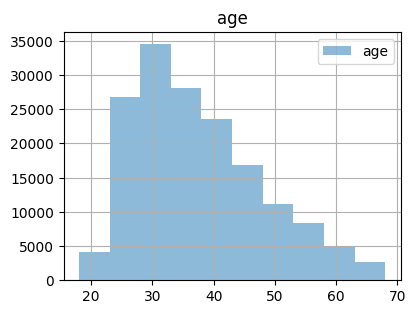

Column age 
	Statistic value - 11253.42 probability - 0.0	UBNORMAL


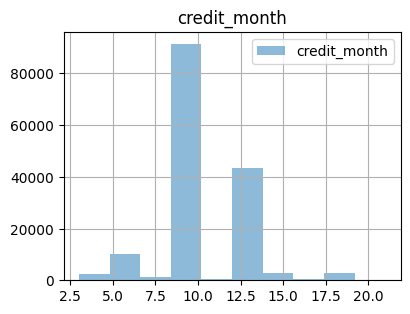

Column credit_month 
	Statistic value - 14827.47 probability - 0.0	UBNORMAL


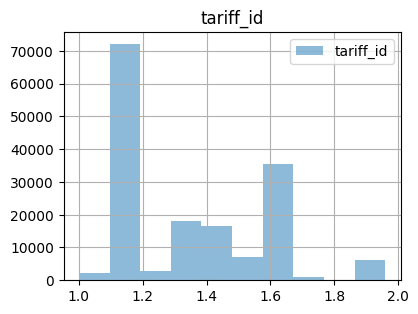

Column tariff_id 
	Statistic value - 18165.81 probability - 0.0	UBNORMAL


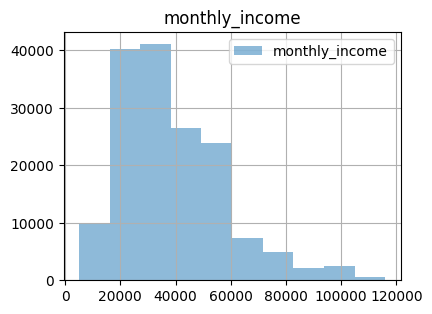

Column monthly_income 
	Statistic value - 28878.98 probability - 0.0	UBNORMAL


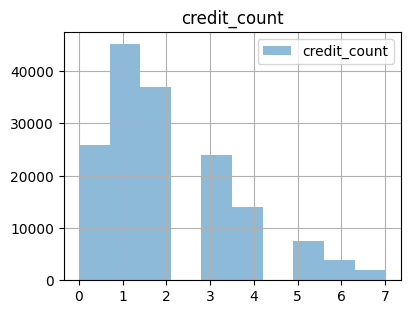

Column credit_count 
	Statistic value - 15399.27 probability - 0.0	UBNORMAL


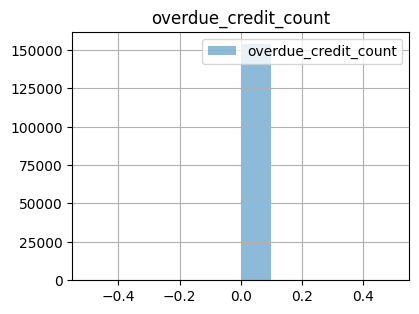

Column overdue_credit_count 
	Statistic value - 0.0 probability - 0.0	UBNORMAL


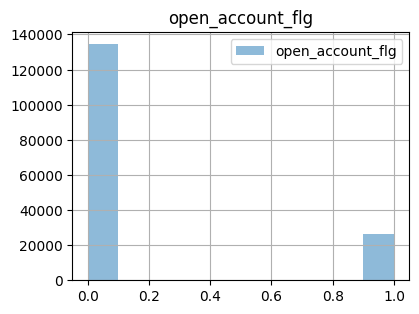

Column open_account_flg 
	Statistic value - 46475.34 probability - 0.0	UBNORMAL


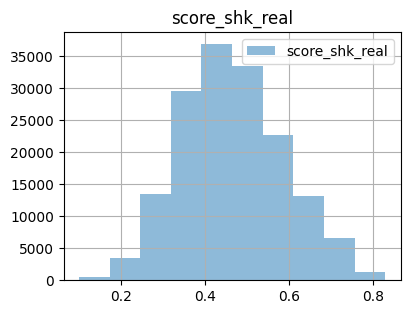

Column score_shk_real 
	Statistic value - 2331.18 probability - 0.0	UBNORMAL


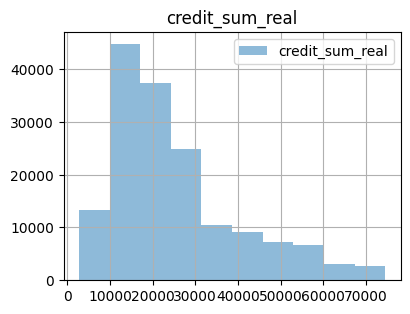

Column credit_sum_real 
	Statistic value - 25686.51 probability - 0.0	UBNORMAL


In [76]:
# exclude emission values outside intervals [mean - 3std; mean + 3std] and analyze distribution and Pearson criterion
for numeric_column in numeric_columns:
    lower_border, upper_border = get_borders(numeric_column)

    # get column values only in [mean - 3std; mean + 3std] interval
    column_df = select(f'''SELECT {numeric_column} FROM {table_name_not_nans} 
                           WHERE {numeric_column} >= {lower_border} AND {numeric_column} <= {upper_border}''')

    # visualize values distribution without emissions
    column_df.hist(layout=(5, 2), figsize=(10, 20), bins=10, alpha=0.5, grid=True, legend=True) 
    plt.show()

    pirson_norm_test(column_df)


Как видно из графиков распределения и анализу по критерию Пирсона, удаление выборосов не приведет к нормальному распределению ни в одном из числовых столбцов, поэтому игнорировать данные не будем. 

In [77]:
distinct_sql = f'SELECT DISTINCT living_region AS unique_living_regions FROM {table_name_not_nans}'
select(distinct_sql)


,unique_living_regions
0,МОСКОВСКАЯ ОБЛ
1,КРАЙ СТАВРОПОЛЬСКИЙ
2,САНКТ-ПЕТЕРБУРГ
3,ОБЛ АРХАНГЕЛЬСКАЯ
4,ХАНТЫ-МАНСИЙСКИЙ АО
...,...
293,РЕСП.БАШКОРТОСТАН
294,КРАЙ. ПЕРМСКИЙ
295,РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ
296,ОБЛ. КИРОВСКАЯ


Приведем колонку "living_region" к нормальномуу виду. На данный момент в ней 298 уникальных записей, однако большинство из них отличается приписками "Г", "ОБЛ", "РЕСП" и т п. К отличиям относятся перестановки слов в записи региона, их полные и неполные названия, формы слов и обозначение региона его номером.

In [78]:
# function for simplify region records by deleting waste words as "Г", "ОБЛ", "РЕСП", etc
def simplify_region(source_region: str) -> str:
    global WASTE_WORDS

    for word in WASTE_WORDS:
        if word in source_region:
            source_region = source_region.replace(word, '')

    source_region = source_region.replace('-', ' ')
    return re.sub(r'[\s]{2,}', ' ', source_region.strip())     # delete extra spaces


In [79]:
# function for evaluating two words
def is_same_records(record1_words: list, record2_words: list) -> bool:
    SAMENESS_TH = 0.49
    min_words_count = min(len(record1_words), len(record2_words))

    # find count of same words in two records
    same_words_count = len(set(record1_words).intersection(set(record2_words)))

    # check if same words count upper some sameness threshold and if record not in created dictionary
    if same_words_count * 1. / min_words_count > SAMENESS_TH:
        return True

    return False


In [80]:
# funcdion for find same region records if they are just rearrangement or tranceted
def find_same_after_rearrangement() -> dict:
    replace_dict = dict()

    # take only complex records
    complex_regions = [item for item in select(f'''SELECT DISTINCT living_region 
                                                   AS unique_living_regions 
                                                   FROM {table_name_not_nans}
                                                   WHERE living_region LIKE "% %"''' ).unique_living_regions.tolist()]
    complex_regions.sort()
    for i in range(len(complex_regions)):
        for j in range(i + 1, len(complex_regions)):
            if is_same_records(complex_regions[i].split(), complex_regions[j].split()) and \
                    complex_regions[j] not in replace_dict.keys():
                replace_dict[complex_regions[j]] = complex_regions[i]

    return replace_dict


In [81]:
# initialize MorphAnalyzer to get words normal form 
morph = pymorphy2.MorphAnalyzer()


In [82]:
# function to safe get word normal form, otherwise return source word 
def get_base_form(word: str) -> str:
    global morph

    try:
        return morph.parse(word)[0].normal_form.upper()     # return in uppercase to simplify comparison
    except:
        return word


In [83]:
# find tranceted and extended region names
# find region names with letters permutations
# find region names in different morphological forms

def find_same_regions() -> dict:
    replace_dict = dict()
    unique_regions_list = select(f'''SELECT DISTINCT living_region AS unique_living_regions 
                                     FROM {table_name_not_nans}''').unique_living_regions.tolist()
    unique_regions_list.sort()

    for unique_region1 in unique_regions_list:
        for unique_region2 in unique_regions_list:
            if unique_region1 == unique_region2 or unique_region2 in replace_dict.values():
                continue

            if ' ' in unique_region2:
                region_words = unique_region2.split()
                if unique_region1 in region_words:
                    replace_dict[unique_region2] = unique_region1

            elif len(unique_region1) == len(unique_region2) and set(unique_region1) == set(unique_region2):
                replace_dict[unique_region2] = unique_region1

            elif get_base_form(unique_region2) == unique_region1:
                replace_dict[unique_region2] = unique_region1

    return replace_dict


In [ ]:
# deleting waste words as "Г", "ОБЛ", "РЕСП", etc from living_region records
WASTE_WORDS = ['ОБЛАСТЬ', 'АОБЛ', 'ОБЛ.', 'ОБЛ', 'КРАЙ.', 'КРАЙ', 'ФЕДЕРАЛЬНЫЙ ОКРУГ', 'АВТОНОМНЫЙ ОКРУГ', ' Г.', 'Г. ', ' Г', 'Г ', 'Р-Н', ' АО', 'АО ', 'РЕСПУБЛИКА', 'РЕСП.', 'РЕСП', '.']

sql_str = f'UPDATE {table_name_not_nans} SET living_region = CASE'
for word in WASTE_WORDS:
    sql_str = f'''{sql_str} WHEN living_region LIKE "%{word}%" 
                  THEN trim(replace(replace(living_region, "{word}", ""), "-", " "))'''
sql_str = f'{sql_str} ELSE trim(replace(living_region, "-", " ")) END'

con.executescript(sql_str)


In [85]:
# create dictionaries for replace same records, numers records, misspelled records
replace_dict = find_same_after_rearrangement()
replace_dict.update(find_same_regions())
replace_dict.update({'74': 'ЧЕЛЯБИНСКАЯ', '98': 'САНКТ ПЕТЕРБУРГ', 
                     'МОСКОВСКАЯ': 'МОСКВА', 'МОСКВОСКАЯ': 'МОСКВА'})
sorted_dict = dict(sorted(replace_dict.items(), key=lambda x: len(x[0]), reverse=True))

[print(key , '->', value) for key, value in sorted_dict.items()]
print()


ХАНТЫ МАНСИЙСКИЙ    ЮГРА -> АО ХАНТЫ МАНСИЙСКИЙ    Ю
СЕВЕРНАЯ ОСЕТИЯ   АЛАНИЯ -> СЕВ ОСЕТИЯ   АЛАНИЯ
ЧУВАШСКАЯ    ЧУВАШИЯ -> ЧУВАШСКАЯ
ЕВРЕЙСКАЯ АВТОНОМНАЯ -> ЕВРЕЙСКАЯ
ЧУВАШСКАЯ   ЧУВАШИЯ -> ЧУВАШСКАЯ
ЧУВАШИЯ ЧУВАШСКАЯ -> ЧУВАШСКАЯ
ХАНТЫ МАНСИЙСКИЙ -> АО ХАНТЫ МАНСИЙСКИЙ    Ю
ЯМАЛО НЕНЕЦКИЙ -> НЕНЕЦКИЙ
САХА /ЯКУТИЯ/ -> САХА
САХА (ЯКУТИЯ) -> САХА
КАМЧАТСКАЯ -> КАМЧАТСКИЙ
МОСКОВСКАЯ -> МОСКВА
МОСКВОСКАЯ -> МОСКВА
БРЯНСКАЯ -> БРЯНСКИЙ
ПЕРМСКАЯ -> ПЕРМСКИЙ
74 -> ЧЕЛЯБИНСКАЯ
98 -> САНКТ ПЕТЕРБУРГ



In [ ]:
# create sql string to update region names according to dictionary
sql_str = f'UPDATE {table_name_not_nans} SET living_region = CASE'

for key, value in sorted_dict.items():
    sql_str = f'''{sql_str} WHEN living_region = "{key}" THEN "{value}"'''
sql_str = f'{sql_str} ELSE living_region END'

con.executescript(sql_str)


По выводу ячейки ниже видно, что кол-во уникальных названий регионов сократилось до 89 записей.

In [87]:
select(distinct_sql)


,unique_living_regions
0,МОСКВА
1,СТАВРОПОЛЬСКИЙ
2,САНКТ ПЕТЕРБУРГ
3,АРХАНГЕЛЬСКАЯ
4,АО ХАНТЫ МАНСИЙСКИЙ Ю
...,...
84,ЧИТИНСКАЯ
85,МЫТИЩИНСКИЙ
86,ЭВЕНКИЙСКИЙ
87,ГУСЬ ХРУСТАЛЬНЫЙ


Для построения кореляции объединим города по федеральным округам. В папку положим csv-файл, содержащий колонку с названием географического субъекта ('subject') и колонку с соответствующим ему федеральным округом ('district'). Информация взята с таблицы сайта <a href="https://ru.wikipedia.org/wiki/%D0%9F%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C_%D1%81%D1%83%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B9_%D0%A4%D0%B5%D0%B4%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B8">Википедия</a>.

In [88]:
dictionary_file = 'Districts_dictionary.csv'
districts_df = pd.read_csv(dictionary_file)

districts_df


,subject,district
0,Республика Саха (Якутия),Дальневосточный
1,Хабаровский край,Дальневосточный
2,Чукотский автономный округ,Дальневосточный
3,Камчатский край,Дальневосточный
4,Магаданская область,Дальневосточный
...,...,...
80,Республика Калмыкия,Южный
81,Астраханская область,Южный
82,Республика Крым,Южный
83,Республика Адыгея,Южный


In [89]:
# make all records in table uppercase as in our work table with credit information
districts_df = districts_df.apply(lambda x: x.str.upper())

# make subject items simply as in 'living_region' column of credit table
districts_df['subject'] = districts_df['subject'].apply(simplify_region)

# create dictionary from district DataFrame columns to simplify search
target_regions_dict = dict(zip(districts_df['subject'].tolist(), districts_df['district'].tolist()))

[print(key , '->', value) for key, value in target_regions_dict.items()]
print()


САХА (ЯКУТИЯ) -> ДАЛЬНЕВОСТОЧНЫЙ
ХАБАРОВСКИЙ -> ДАЛЬНЕВОСТОЧНЫЙ
ЧУКОТСКИЙ -> ДАЛЬНЕВОСТОЧНЫЙ
КАМЧАТСКИЙ -> ДАЛЬНЕВОСТОЧНЫЙ
МАГАДАНСКАЯ -> ДАЛЬНЕВОСТОЧНЫЙ
ЗАБАЙКАЛЬСКИЙ -> ДАЛЬНЕВОСТОЧНЫЙ
АМУРСКАЯ -> ДАЛЬНЕВОСТОЧНЫЙ
БУРЯТИЯ -> ДАЛЬНЕВОСТОЧНЫЙ
ПРИМОРСКИЙ -> ДАЛЬНЕВОСТОЧНЫЙ
САХАЛИНСКАЯ -> ДАЛЬНЕВОСТОЧНЫЙ
ЕВРЕЙСКАЯ АВТОНОМНАЯ -> ДАЛЬНЕВОСТОЧНЫЙ
ПЕРМСКИЙ -> ПРИВОЛЖСКИЙ
БАШКОРТОСТАН -> ПРИВОЛЖСКИЙ
ОРЕНБУРГСКАЯ -> ПРИВОЛЖСКИЙ
КИРОВСКАЯ -> ПРИВОЛЖСКИЙ
САРАТОВСКАЯ -> ПРИВОЛЖСКИЙ
НИЖЕГОРОДСКАЯ -> ПРИВОЛЖСКИЙ
ТАТАРСТАН -> ПРИВОЛЖСКИЙ
САМАРСКАЯ -> ПРИВОЛЖСКИЙ
ПЕНЗЕНСКАЯ -> ПРИВОЛЖСКИЙ
УДМУРТСКАЯ -> ПРИВОЛЖСКИЙ
УЛЬЯНОВСКАЯ -> ПРИВОЛЖСКИЙ
МОРДОВИЯ -> ПРИВОЛЖСКИЙ
МАРИЙ ЭЛ -> ПРИВОЛЖСКИЙ
ЧУВАШСКАЯ -> ПРИВОЛЖСКИЙ
АРХАНГЕЛЬСКАЯ -> СЕВЕРО-ЗАПАДНЫЙ
КОМИ -> СЕВЕРО-ЗАПАДНЫЙ
КАРЕЛИЯ -> СЕВЕРО-ЗАПАДНЫЙ
НЕНЕЦКИЙ -> СЕВЕРО-ЗАПАДНЫЙ
МУРМАНСКАЯ -> СЕВЕРО-ЗАПАДНЫЙ
ВОЛОГОДСКАЯ -> СЕВЕРО-ЗАПАДНЫЙ
ЛЕНИНГРАДСКАЯ -> СЕВЕРО-ЗАПАДНЫЙ
ПСКОВСКАЯ -> СЕВЕРО-ЗАПАДНЫЙ
НОВГОРОДСКАЯ -> СЕВЕРО-ЗАПАДНЫЙ
КАЛИНИНГРАДСКАЯ -> СЕВЕРО-З

In [90]:
# function for find district for all geographical subjects from 'living_region' in credit data table 
def extend_distincts_dict():
    global target_regions_dict

    unique_regions_list = select(distinct_sql).unique_living_regions.tolist()
    unique_regions_list.sort()

    for source_region in unique_regions_list:
        # search district in subjects keys
        if source_region in target_regions_dict.keys():
            continue

        # analyze if living region name is tranceted or extended but same with some subject in district dictionary
        dict_keys = list(target_regions_dict.keys())
        for target_region in dict_keys:
            if is_same_records(source_region.split(), target_region.split()):
                # add new pair to dicttionary because there are same living region names in credit data table
                target_regions_dict[source_region] = target_regions_dict[target_region]
                continue

        # analyze if region name is morphological form and normal form is in district dictionary keys
        source_morph = get_base_form(source_region)
        if source_morph in target_regions_dict.keys():
            target_regions_dict[source_region] = target_regions_dict[source_morph]
            continue

        # analyze if region name in district dictionary keys is morphological form and normal form is the same with living region name
        # this circle at the end of the function because it is less likely case and we hope, we won't check it often
        for target_region in dict_keys:
            if source_region == get_base_form(target_region):
                target_regions_dict[source_region] = target_regions_dict[target_region]
                continue

        # less likely case if living region name is the same with federal district
        if source_region in set(target_regions_dict.values()):
            target_regions_dict[source_region] = source_region
            continue

        # extend regions dictionary with key 'OTHER'
        target_regions_dict[source_region] = 'OTHER'


In [91]:
# extend dictionary to replace regions with districts
extend_distincts_dict()

[print(key , '->', value) for key, value in target_regions_dict.items()]
print()


САХА (ЯКУТИЯ) -> ДАЛЬНЕВОСТОЧНЫЙ
ХАБАРОВСКИЙ -> ДАЛЬНЕВОСТОЧНЫЙ
ЧУКОТСКИЙ -> ДАЛЬНЕВОСТОЧНЫЙ
КАМЧАТСКИЙ -> ДАЛЬНЕВОСТОЧНЫЙ
МАГАДАНСКАЯ -> ДАЛЬНЕВОСТОЧНЫЙ
ЗАБАЙКАЛЬСКИЙ -> ДАЛЬНЕВОСТОЧНЫЙ
АМУРСКАЯ -> ДАЛЬНЕВОСТОЧНЫЙ
БУРЯТИЯ -> ДАЛЬНЕВОСТОЧНЫЙ
ПРИМОРСКИЙ -> ДАЛЬНЕВОСТОЧНЫЙ
САХАЛИНСКАЯ -> ДАЛЬНЕВОСТОЧНЫЙ
ЕВРЕЙСКАЯ АВТОНОМНАЯ -> ДАЛЬНЕВОСТОЧНЫЙ
ПЕРМСКИЙ -> ПРИВОЛЖСКИЙ
БАШКОРТОСТАН -> ПРИВОЛЖСКИЙ
ОРЕНБУРГСКАЯ -> ПРИВОЛЖСКИЙ
КИРОВСКАЯ -> ПРИВОЛЖСКИЙ
САРАТОВСКАЯ -> ПРИВОЛЖСКИЙ
НИЖЕГОРОДСКАЯ -> ПРИВОЛЖСКИЙ
ТАТАРСТАН -> ПРИВОЛЖСКИЙ
САМАРСКАЯ -> ПРИВОЛЖСКИЙ
ПЕНЗЕНСКАЯ -> ПРИВОЛЖСКИЙ
УДМУРТСКАЯ -> ПРИВОЛЖСКИЙ
УЛЬЯНОВСКАЯ -> ПРИВОЛЖСКИЙ
МОРДОВИЯ -> ПРИВОЛЖСКИЙ
МАРИЙ ЭЛ -> ПРИВОЛЖСКИЙ
ЧУВАШСКАЯ -> ПРИВОЛЖСКИЙ
АРХАНГЕЛЬСКАЯ -> СЕВЕРО-ЗАПАДНЫЙ
КОМИ -> СЕВЕРО-ЗАПАДНЫЙ
КАРЕЛИЯ -> СЕВЕРО-ЗАПАДНЫЙ
НЕНЕЦКИЙ -> СЕВЕРО-ЗАПАДНЫЙ
МУРМАНСКАЯ -> СЕВЕРО-ЗАПАДНЫЙ
ВОЛОГОДСКАЯ -> СЕВЕРО-ЗАПАДНЫЙ
ЛЕНИНГРАДСКАЯ -> СЕВЕРО-ЗАПАДНЫЙ
ПСКОВСКАЯ -> СЕВЕРО-ЗАПАДНЫЙ
НОВГОРОДСКАЯ -> СЕВЕРО-ЗАПАДНЫЙ
КАЛИНИНГРАДСКАЯ -> СЕВЕРО-З

In [ ]:
# create sql string to update region names according to their districts
sql_str = f'UPDATE {table_name_not_nans} SET living_region = CASE'

for key, value in target_regions_dict.items():
    sql_str = f'''{sql_str} WHEN living_region = "{key}" THEN "{value}"'''
sql_str = f'{sql_str} ELSE living_region END'

con.executescript(sql_str)


Заменяем названия регионов из таблицы о кредитах на названия федеральных округов РФ. В результате все записи, кроме 6703, были сгруппированы по округам. Оставим эти записи в категории 'OTHER'.

In [ ]:
# show unique living_region records
select(f'''SELECT living_region, count(client_id) AS living_region_records 
           FROM {table_name_not_nans} GROUP BY living_region''')


,living_region,living_region_records
0,OTHER,6703
1,ДАЛЬНЕВОСТОЧНЫЙ,9210
2,ПРИВОЛЖСКИЙ,34349
3,СЕВЕРО-ЗАПАДНЫЙ,22905
4,СЕВЕРО-КАВКАЗСКИЙ,4577
5,СИБИРСКИЙ,14848
6,УРАЛЬСКИЙ,15419
7,ЦЕНТРАЛЬНЫЙ,35730
8,ЮЖНЫЙ,17590


In [96]:
# create sql-request to find non-numeric columns
non_numeric_columns = select(f'''SELECT name FROM pragma_table_info("{table_name_not_nans}") 
                                 WHERE type = "TEXT" AND name != "living_region"''').name.tolist()
non_numeric_columns


['gender', 'marital_status', 'job_position', 'education']

In [ ]:
# encode non-numeric columns
label_encoder = LabelEncoder()

# create sql request string to make INTEGER columns 
# and fill they with int encoded values, drop initial text columns
update_sql = ''
for column in non_numeric_columns:
    column_to_encode = select(f'''SELECT DISTINCT {column} AS unique_{column} 
                                  FROM {table_name_not_nans}''')[f'unique_{column}'].tolist()
    encoded_column = label_encoder.fit_transform(column_to_encode)
    column_dict = dict(zip(column_to_encode, encoded_column))
    
    sql_str = f'UPDATE {table_name_not_nans} SET {column}_int = CASE'
    for key, value in column_dict.items():
        sql_str = f'''{sql_str} WHEN {column} = "{key}" THEN {value}'''
    sql_str = f'{sql_str} ELSE -1 END;'
    
    update_sql = f'''{update_sql}
                     ALTER TABLE {table_name_not_nans} 
                     ADD COLUMN {column}_int INTEGER;
                     {sql_str}
                     ALTER TABLE {table_name_not_nans} DROP COLUMN {column};'''
con.executescript(update_sql)


In [ ]:
# show table columns info
select(table_info_sql)


,cid,name,type,notnull,dflt_value,pk
0,0,client_id,INTEGER,0,None,0
1,1,age,REAL,0,None,0
2,2,credit_month,INTEGER,0,None,0
3,3,tariff_id,REAL,0,None,0
4,4,living_region,TEXT,0,None,0
5,5,monthly_income,REAL,0,None,0
6,6,credit_count,REAL,0,None,0
7,7,overdue_credit_count,REAL,0,None,0
8,8,open_account_flg,INTEGER,0,None,0
9,9,score_shk_real,REAL,0,None,0


In [111]:
select(f'''SELECT gender_int, marital_status_int, job_position_int, education_int
           FROM {table_name_not_nans}''')


,gender_int,marital_status_int,job_position_int,education_int
0,0,3,12,1
1,0,3,12,1
2,1,2,12,3
3,1,2,12,3
4,1,2,5,1
...,...,...,...,...
161326,0,3,12,1
161327,0,2,12,3
161328,0,3,12,1
161329,0,1,8,3


In [ ]:
# encode living_region column with OneHoEncoder
hot_encoding_column = 'living_region'
hot_encoder = OneHotEncoder(sparse_output=False)

regions_df = select(distinct_sql)
one_hot_encoded = hot_encoder.fit_transform(regions_df)
one_hot_df = pd.DataFrame(one_hot_encoded, columns=hot_encoder.get_feature_names_out(['unique_living_regions']))

unique_regions_lst = regions_df.unique_living_regions.tolist()

# create sql request string to make REAL columns 
# and fill they with float encoded values, drop initial text column
update_sql = ''
for region in unique_regions_lst:
    column_dict = dict(zip(unique_regions_lst, 
                           one_hot_df[f'unique_living_regions_{region}'].tolist()))

    region_column = region.replace('-', '') + '_real'
    sql_str = f'''UPDATE {table_name_not_nans} 
                  SET {region_column} = CASE'''
    for key, value in column_dict.items():
        sql_str = f'{sql_str} WHEN {hot_encoding_column} = "{key}" THEN {value}'
    sql_str = f'{sql_str} ELSE -1.0 END;'
    
    update_sql = f'''{update_sql}
                     ALTER TABLE {table_name_not_nans} 
                     ADD COLUMN {region_column} REAL;
                     {sql_str}'''

update_sql = f'''{update_sql} 
                 ALTER TABLE {table_name_not_nans} 
                 DROP COLUMN {hot_encoding_column};'''
  
con.executescript(update_sql)    


In [144]:
# show table columns info
select(table_info_sql)


,cid,name,type,notnull,dflt_value,pk
0,0,client_id,INTEGER,0,None,0
1,1,age,REAL,0,None,0
2,2,credit_month,INTEGER,0,None,0
3,3,tariff_id,REAL,0,None,0
4,4,monthly_income,REAL,0,None,0
5,5,credit_count,REAL,0,None,0
6,6,overdue_credit_count,REAL,0,None,0
7,7,open_account_flg,INTEGER,0,None,0
8,8,score_shk_real,REAL,0,None,0
9,9,credit_sum_real,REAL,0,None,0


In [145]:
select(show_table_sql)


,client_id,age,credit_month,tariff_id,monthly_income,credit_count,overdue_credit_count,open_account_flg,score_shk_real,credit_sum_real,...,education_int,ЦЕНТРАЛЬНЫЙ_real,СЕВЕРОКАВКАЗСКИЙ_real,СЕВЕРОЗАПАДНЫЙ_real,OTHER_real,ПРИВОЛЖСКИЙ_real,ЮЖНЫЙ_real,СИБИРСКИЙ_real,УРАЛЬСКИЙ_real,ДАЛЬНЕВОСТОЧНЫЙ_real
0,8,26.0,10,1.10,60000.0,3.0,0.0,0,0.512525,47878.00,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,32.0,10,1.10,39500.0,7.0,0.0,0,0.465026,26268.00,...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,26.0,14,1.00,36000.0,2.0,0.0,0,0.445430,16793.00,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13,37.0,10,1.60,70000.0,1.0,0.0,0,0.691609,42289.00,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14,43.0,10,1.10,60000.0,7.0,0.0,0,0.341164,57567.00,...,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161326,170742,27.0,12,1.10,40000.0,6.0,0.0,0,0.535257,64867.00,...,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
161327,170743,24.0,6,1.60,30000.0,1.0,0.0,0,0.573287,17640.00,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
161328,170744,31.0,10,1.32,40000.0,1.0,0.0,0,0.416098,27556.47,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
161329,170745,53.0,12,1.10,31000.0,2.0,0.0,0,0.482595,6189.00,...,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Создадим столбец с нормированными значениями зарплаты для разных полов. Закодируем таким образом: зарплата ниже средней для одного пола (закодированого как 0) = 0.0, не ниже средней = 0.4, не выше средней для второго пола (закодированого как 1) = 0.8, выше средней = 1.0. Удалим столбец с полом.

In [153]:
avg_income = select(f'''SELECT avg(monthly_income) AS avg_monthly_income
                        FROM {table_name_not_nans}''').avg_monthly_income.loc[0]

merge_sql = f'''ALTER TABLE {table_name_not_nans} ADD COLUMN gender_income REAL;
                UPDATE {table_name_not_nans} SET gender_income = CASE
                WHEN gender_int = 0 AND monthly_income < {avg_income} THEN 0.0
                WHEN gender_int = 0 AND monthly_income >= {avg_income} THEN 0.4
                WHEN gender_int = 1 AND monthly_income <= {avg_income} THEN 0.8
                WHEN gender_int = 1 AND monthly_income > {avg_income} THEN 1.0
                ELSE 0.0 END; ALTER TABLE {table_name_not_nans} DROP COLUMN gender_int'''
con.executescript(merge_sql)


In [154]:
# show table columns info
select(table_info_sql)


,cid,name,type,notnull,dflt_value,pk
0,0,client_id,INTEGER,0,None,0
1,1,age,REAL,0,None,0
2,2,credit_month,INTEGER,0,None,0
3,3,tariff_id,REAL,0,None,0
4,4,monthly_income,REAL,0,None,0
5,5,credit_count,REAL,0,None,0
6,6,overdue_credit_count,REAL,0,None,0
7,7,open_account_flg,INTEGER,0,None,0
8,8,score_shk_real,REAL,0,None,0
9,9,credit_sum_real,REAL,0,None,0


In [155]:
select(show_table_sql)


,client_id,age,credit_month,tariff_id,monthly_income,credit_count,overdue_credit_count,open_account_flg,score_shk_real,credit_sum_real,...,ЦЕНТРАЛЬНЫЙ_real,СЕВЕРОКАВКАЗСКИЙ_real,СЕВЕРОЗАПАДНЫЙ_real,OTHER_real,ПРИВОЛЖСКИЙ_real,ЮЖНЫЙ_real,СИБИРСКИЙ_real,УРАЛЬСКИЙ_real,ДАЛЬНЕВОСТОЧНЫЙ_real,gender_income
0,8,26.0,10,1.10,60000.0,3.0,0.0,0,0.512525,47878.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4
1,10,32.0,10,1.10,39500.0,7.0,0.0,0,0.465026,26268.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,26.0,14,1.00,36000.0,2.0,0.0,0,0.445430,16793.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8
3,13,37.0,10,1.60,70000.0,1.0,0.0,0,0.691609,42289.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,14,43.0,10,1.10,60000.0,7.0,0.0,0,0.341164,57567.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161326,170742,27.0,12,1.10,40000.0,6.0,0.0,0,0.535257,64867.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
161327,170743,24.0,6,1.60,30000.0,1.0,0.0,0,0.573287,17640.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161328,170744,31.0,10,1.32,40000.0,1.0,0.0,0,0.416098,27556.47,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
161329,170745,53.0,12,1.10,31000.0,2.0,0.0,0,0.482595,6189.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Создадим столбец с нормированными значениями зарплаты для разных регионов. Закодируем таким образом: зарплата не выше средней для Центрального района РФ = 0.2, для других районов - 0.0, выше средней для Центрального района РФ = 1.0, для других районов - 0.6.

In [ ]:
merge_sql = f'''ALTER TABLE {table_name_not_nans} ADD COLUMN region_income REAL;
                UPDATE {table_name_not_nans} SET region_income = CASE
                WHEN ЦЕНТРАЛЬНЫЙ_real = 0.0 AND monthly_income <= {avg_income} THEN 0.0
                WHEN ЦЕНТРАЛЬНЫЙ_real = 0.0 AND monthly_income > {avg_income} THEN 0.6
                WHEN ЦЕНТРАЛЬНЫЙ_real = 1.0 AND monthly_income <= {avg_income} THEN 0.2
                WHEN ЦЕНТРАЛЬНЫЙ_real = 1.0 AND monthly_income > {avg_income} THEN 1.0
                ELSE 0.0 END'''
con.executescript(merge_sql)


In [157]:
select(table_info_sql)


,cid,name,type,notnull,dflt_value,pk
0,0,client_id,INTEGER,0,None,0
1,1,age,REAL,0,None,0
2,2,credit_month,INTEGER,0,None,0
3,3,tariff_id,REAL,0,None,0
4,4,monthly_income,REAL,0,None,0
5,5,credit_count,REAL,0,None,0
6,6,overdue_credit_count,REAL,0,None,0
7,7,open_account_flg,INTEGER,0,None,0
8,8,score_shk_real,REAL,0,None,0
9,9,credit_sum_real,REAL,0,None,0


In [158]:
select(show_table_sql)


,client_id,age,credit_month,tariff_id,monthly_income,credit_count,overdue_credit_count,open_account_flg,score_shk_real,credit_sum_real,...,СЕВЕРОКАВКАЗСКИЙ_real,СЕВЕРОЗАПАДНЫЙ_real,OTHER_real,ПРИВОЛЖСКИЙ_real,ЮЖНЫЙ_real,СИБИРСКИЙ_real,УРАЛЬСКИЙ_real,ДАЛЬНЕВОСТОЧНЫЙ_real,gender_income,region_income
0,8,26.0,10,1.10,60000.0,3.0,0.0,0,0.512525,47878.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,1.0
1,10,32.0,10,1.10,39500.0,7.0,0.0,0,0.465026,26268.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,26.0,14,1.00,36000.0,2.0,0.0,0,0.445430,16793.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0
3,13,37.0,10,1.60,70000.0,1.0,0.0,0,0.691609,42289.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.6
4,14,43.0,10,1.10,60000.0,7.0,0.0,0,0.341164,57567.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161326,170742,27.0,12,1.10,40000.0,6.0,0.0,0,0.535257,64867.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
161327,170743,24.0,6,1.60,30000.0,1.0,0.0,0,0.573287,17640.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161328,170744,31.0,10,1.32,40000.0,1.0,0.0,0,0.416098,27556.47,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
161329,170745,53.0,12,1.10,31000.0,2.0,0.0,0,0.482595,6189.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Нормализум значения столбцов. Считаем столбец нормализованым, если его значения лежат в промежутке [0.0, 1.0]. Приводим значения столбца к данному промежутку, если необходимо.

In [ ]:
# get table columns names
columns_list = select(f'''SELECT name FROM pragma_table_info("{table_name_not_nans}")
                          WHERE type = "REAL"''').name.tolist()

norm_sql = ''
for column in columns_list:
    min_val, max_val, update_flag = select(f'''SELECT min({column}) AS min_val, 
                                               max({column}) AS max_val,
                                               min({column}) != 0 
                                               OR max({column}) != 1 
                                               OR min({column}) = max({column}) AS updata_flag 
                                               FROM {table_name_not_nans}''').loc[0]
    if update_flag:
        norm_sql = f'''{norm_sql} UPDATE {table_name_not_nans} 
                       SET {column} = ({column} - {min_val}) / ({max_val} - {min_val});'''

con.executescript(norm_sql)


In [184]:
select(show_table_sql)

,client_id,age,credit_month,tariff_id,monthly_income,credit_count,overdue_credit_count,open_account_flg,score_shk_real,credit_sum_real,...,СЕВЕРОКАВКАЗСКИЙ_real,СЕВЕРОЗАПАДНЫЙ_real,OTHER_real,ПРИВОЛЖСКИЙ_real,ЮЖНЫЙ_real,СИБИРСКИЙ_real,УРАЛЬСКИЙ_real,ДАЛЬНЕВОСТОЧНЫЙ_real,gender_income,region_income
0,8,0.150943,10,0.104167,0.058201,0.142857,0.0,0,0.525060,0.228841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,1.0
1,10,0.264151,10,0.104167,0.036508,0.333333,0.0,0,0.476400,0.119292,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,0.150943,14,0.000000,0.032804,0.095238,0.0,0,0.456324,0.071260,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0
3,13,0.358491,10,0.625000,0.068783,0.047619,0.0,0,0.708524,0.200508,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.6
4,14,0.471698,10,0.104167,0.058201,0.333333,0.0,0,0.349508,0.277957,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161326,170742,0.169811,12,0.104167,0.037037,0.285714,0.0,0,0.548348,0.314964,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
161327,170743,0.113208,6,0.625000,0.026455,0.047619,0.0,0,0.587308,0.075554,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161328,170744,0.245283,10,0.333333,0.037037,0.047619,0.0,0,0.426275,0.125824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
161329,170745,0.660377,12,0.104167,0.027513,0.095238,0.0,0,0.494398,0.017504,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Разобъем данные на обучающую и тестовую выборки.<br>Рамер обучающей выборки = 145197, записей тестовой = 16134.

In [ ]:
train_df, test_df = train_test_split(select(show_table_sql), test_size=0.1, random_state=0)
print(train_df, '\n', test_df)


        client_id       age  credit_month  tariff_id  monthly_income  \
4238         4514  0.207547            10   0.104167        0.031746   
133205     140962  0.433962            10   0.197917        0.013757   
39475       41791  0.226415            10   0.625000        0.068783   
103545     109536  0.452830            10   0.104167        0.026455   
16240       17207  0.056604            12   0.625000        0.068783   
...           ...       ...           ...        ...             ...   
97639      103316  0.188679            10   0.104167        0.052910   
95939      101513  0.320755            10   0.333333        0.063492   
152315     161181  0.377358            24   0.104167        0.021164   
117952     124831  0.698113            10   0.333333        0.045503   
43567       46135  0.452830            10   0.104167        0.016931   

        credit_count  overdue_credit_count  open_account_flg  score_shk_real  \
4238        0.000000              0.000000             

В ходе работы с sqlite3 через pandas были изучены основные виды запросов к базам данных. В процессе работы стало понятно, что sqlite3 не содержит некоторых удобых функций для работы с данными в сравнении с питоном и другими базами даных, а также работает не быстро через библиотеку pandas.